### Banking Discipline and Elasticity
J M Applegate.
##### CAS543 Complexity Economics
The notebook presents basic banking discipline and elasticity dynamics.  
A set of $n$ of retail customers are served by $N$ banks.  
Banks hold reserves as a central bank according to a specified reserve requirement.  
Customer transactions take place every day, and every night the reserve accounts need to be non-negative.  
Surplus banks lend to deficit banks as requested to meet the overnight non-negative reserve requirement.  

In [1]:
# import packages
from ipywidgets import widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import seaborn as sns
import random
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})
rng = np.random.default_rng()

In [2]:
# set parameters
n = 1000 # number of retail customers
N = 10 # number of banks
steps = 100 # number of simulation runs
tau = 200 # parameter for poisson function, mean number of transactions a step
reserve_reqmt = .5 # percentage of initial retail deposits as reserves
cb_rate = .2 # central bank lending rate
bailouts_are_allowed = True
backstop_rate = .25 # central bank backstop rate
bailout_deficit_multiplier = 3 # multiplier on current deficit to calculate bailout amount. this is not ideal but we lack global state
premium_basis = .1 # basis for risk premium
broker_network_fraction = 1 # TODO isnʻt working as intended. fraction of banks that can be "reached" by a broker 
max_balance = 100 # upper limit for initial retail deposits

Updates: We have added a risk assessment and pricing component to the intrabank lending model. `update_net_positions` updates a risk assessment factor for each bank based on how they are positioned with respect to their reserve requirements. `get_lender_quote` is called for every lender to obtain a priced proposition for a loan to the bank in question based on the risk assessment. 

In [3]:
# define utility function

# New!
def get_lender_quote(lender, borrower, reserves, net_positions, risk_appetites, cb_rate):
    # get_lender_quote simulates a agent shopping for quotes for overnight loans
    # thus giving us a pricing mechanism based on risk preferenc
    risk_premium = max(premium_basis, -net_positions[borrower]) * premium_basis # always charge at least cb_rate + premium_basis
    
    # factor in the lender's risk appetite
    adjusted_premium = risk_premium * (1 - risk_appetites[lender])

    # calculate with an arbitrary upper bound of 3x the cb_rate
    quote = min(cb_rate + adjusted_premium, 3 * cb_rate)

    # display(f"Lender {lender} has a risk appetite of {risk_appetites[lender]}")
    # display(f"Borrower {borrower} has a net position of {net_positions[borrower]}")
    # display(f"The adjusted premium for lender {lender} is {adjusted_premium}")
    # display(f"The quote for lender {lender} is {quote}")

    return (quote, True)

# New!
def calculate_avg_overnight_rate(loans, rates):
    total_weighted_cost = 0
    total_loan_volume = 0
    
    # Sum up (loan * rate) for all loans
    for bank_loans, bank_rates in zip(loans, rates):
        for loan, rate in zip(bank_loans, bank_rates):
            total_weighted_cost += loan * rate
            total_loan_volume += loan
    
    # Calculate weighted average, return 0 if no loans
    if total_loan_volume > 0:
        return total_weighted_cost / total_loan_volume
    return 0

# define model functions

# New!
def update_net_positions(N, loans, rates, reserves, customers, banks, balances):
    # For all of our banks, we want to calculate how well they are keeping up with the reserve requirement
    # This is sort of a proxy for bank health in light of the fact that
    # loans in the model are simulated rather than operational.
    # Note that this could also be calculated on the spot from reserves and loans, but
    # that would be a pain in the neck. Also, maybe we would want to get more clever about
    # bank health in the future.
    
    # Initialize net positions list
    net_positions = []
    
    # Calculate required reserves for each bank
    for B in range(N):
        # Calculate total deposits for this bank
        bank_deposits = 0
        for c in range(len(customers)):
            if banks[c] == B:
                bank_deposits += balances[c]
                
        required_reserves = bank_deposits * reserve_reqmt
        
        # Calculate loan costs
        loan_principal = sum(loans[B])
        
        # Calculate interest costs
        interest_cost = 0
        for loan, rate in zip(loans[B], rates[B]):
            interest_cost += loan * rate
        
         # Calculate net position as a ratio to required reserves
        if required_reserves > 0:  # Avoid division by zero
            net_position = (reserves[B] - loan_principal - interest_cost - required_reserves) / required_reserves
        else:
            net_position = 0 # TODO not sure about conditions with no required reserves
        
        net_positions.append(net_position)
    return net_positions

# Existing!
# create reserves from retail deposit amounts
def create_reserves(N, customers, banks, balances, reserve_reqmt):
    deposits = []
    for B in range(N):
        bank_deposits = 0
        for c in customers:
            if banks[c] == B:
                bank_deposits += balances[c]
        deposits.append(bank_deposits)
    reserves = [reserve_reqmt * d for d in deposits]
    return(reserves)

# retail customers conduct transactions which are settled through aggregated central bank reserve transfers
def retail_transactions(tau, customers, banks, balances, reserves):
    transfers = rng.poisson(tau)
    originators = random.choices(customers, weights = balances, k=transfers) # originators weighted on bank balances
    #originators = random.choices(customers, k=transfers) #unwe
    percentages = rng.random(transfers).tolist()
    recipients = []
    for o in originators:
        others = [c for c in customers if c != o]
        other_balances = [b for i, b in enumerate(balances) if i != o] 
        recipient = random.choices(others, weights = other_balances)[0] # recipients weighted on bank balances
        #recipient = random.choices(others)[0]
        recipients.append(recipient)
    originating_banks = [banks[o] for o in originators]
    receiving_banks = [banks[r] for r in recipients]
    for t in range(transfers):
        amount = percentages[t] * balances[originators[t]]
        balances[recipients[t]] += amount
        balances[originators[t]] -= amount
        reserves[receiving_banks[t]] += amount
        reserves[originating_banks[t]] -= amount
    return(balances, reserves)

# surplus banks lend to deficit banks at the end of the day to ensure all reserve accounts are non-negative
def settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites):
    # in the unlikely event of a bailout...
    bailouts = []

    deficit_banks = [i for i, b in enumerate(reserves) if b < 0]
    possible_lenders = [x for x in range(N) if x not in deficit_banks]
    random.shuffle(possible_lenders)

    # in order to settle deficits, we need to get quotes from lenders
    # we simulate using a broker with "limited reach" to other banks
    # the broker will then choose the lowest quote and lend to the borrower

    broker_reach = int(N * broker_network_fraction)

    for i in deficit_banks:
        if len(possible_lenders) >= broker_reach:
            selected_lenders = random.sample(possible_lenders, broker_reach)
        else:
            selected_lenders = possible_lenders
            
        # Get quotes from each selected lender
        quotes = []
        for lender in selected_lenders:
            quote, can_lend = get_lender_quote(
                lender, i, reserves, net_positions, 
                risk_appetites, cb_rate
            )
            if can_lend:
                quotes.append((lender, quote))
    
        # order the quotes by the quote amount
        if quotes:
            lowest_quotes_first = sorted(quotes, key=lambda x: x[1])
            j = 0
            while reserves[i] < 0 and j < len(lowest_quotes_first):
                lender = lowest_quotes_first[j][0] # the lender id
                quoted_rate = lowest_quotes_first[j][1]
                if reserves[lender] >= abs(reserves[i]):
                    reserves[lender] += reserves[i]
                    display(f"Writing full loan to borrower {i} from lender {lender} for amount {abs(reserves[i])} at rate {quoted_rate}")
                    loans[i].append(abs(reserves[i]))
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] = 0
                    display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")
                elif reserves[lender] > 0:
                    display(f"Writing partial loan to borrower {i} from lender {lender} for amount {reserves[lender]} at rate {quoted_rate}")
                    loans[i].append(reserves[lender])
                    rates[i].append(quoted_rate)
                    lenders[i].append(lender)
                    reserves[i] += reserves[lender]
                    reserves[lender] = 0
                    display(f"Lender {lender} has {reserves[lender]} reserves remaining. Borrower {i} has {reserves[i]} reserves remaining.")                    
                    j += 1
                else:
                    display(f"Lender {lender} has no reserves to lend")
                    j += 1
        
        # if we still have a deficit, we need to call the Fed
        if reserves[i] < 0 and bailouts_are_allowed:
            display(f"Borrower {i} needs a bailout")
            deficit_amount = abs(reserves[i])

            # Expansion on the deficit for recapitalization,
            # not ideal but without global state we would need to dump the entire model into this function, 
            # for now this will have to do, and anyway, arenʻt bailouts crude anyway?
            recap_amount = deficit_amount * bailout_deficit_multiplier   
            loans[i].append(recap_amount)
            rates[i].append(backstop_rate)  # Punitive rate
            lenders[i].append(None)  # None indicates Fed lending
            reserves[i] = deficit_amount  # Leave them with positive reserves equal to original deficit
            
            # after bailout, bank is chastened (????)
            risk_appetites[i] = 0.01

            # report back to the economy
            bailouts.append((i, recap_amount))
        
        if reserves[i] < 0:
            display(f"Borrower {i} reached no lenders")

    return(reserves, loans, rates, lenders, bailouts)

# borrowing banks repay overnight loans
def repay_loans(N, loans, rates, lenders, reserves):
    for B in range(N):
        for i, loan in enumerate(loans[B]):
            rate = rates[B][i] # stored right alongside the loans now, cb_rate baked in.
            lender = lenders[B][i]

            # if lender is  None, itʻs a fed loan
            if lender is not None: # normal interbank loan
                reserves[lender] += loan * (1 + rate)
            # but, still need to deduct from borrowing bank whether Fed or other bank
            reserves[B] -= loan * (1 + rate)

            loans[B].pop(0)
            rates[B].pop(0)
            lenders[B].pop(0)
    return(loans, rates, lenders, reserves)

In [4]:
# initialise data structures
customers = list(range(n))
banks = rng.choice(range(N), n).tolist()
balances = rng.uniform(1, max_balance, n).tolist()
loans = [[] for _ in range(N)]
rates = [[] for _ in range(N)]
lenders = [[] for _ in range(N)]
customer_history = pd.DataFrame()
bank_history = pd.DataFrame()
financial_system_history = pd.DataFrame()

# calculate reserves based on retail deposits
reserves = create_reserves(N, customers, banks, balances, reserve_reqmt)

# we should now be able to initialize our asset positions
net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

# and our risk appetites are simple enough...
risk_appetites = rng.uniform(0, 0.5, N).tolist()

# populate history arrays with initial values
customer_history['step'] = [0] * n
customer_history['id'] = customers
customer_history['balance'] = balances
bank_history['step'] = [0] * N
bank_history['id'] = list(range(N))
bank_history['reserves'] = reserves
bank_history['loans'] = [sum(l0) for l0 in loans]
bank_history['rates'] = [[] for _ in range(N)]
bank_history['net_positions'] = net_positions
bank_history['risk_appetite'] = risk_appetites
# these are vectors but only one history for the whole system. so, no "N"
financial_system_history['step'] = [0]
financial_system_history['average_net_position'] = [0]
financial_system_history['avg_daily_rate'] = [0]
financial_system_history['average_risk_appetite'] = [0]
financial_system_history['fed_recapitalization'] = [None] # 0 to many banks can be taken over by the fed each step, store as list or None

for s in range(1, steps+1):

    display(f"Step {s}")
    
    #repay overnight loans
    loans, rates, lenders, reserves = repay_loans(N, loans, rates, lenders, reserves)
            
    #conduct retail customer activity
    balances, reserves = retail_transactions(tau, customers, banks, balances, reserves)

    #settle negative reserve accounts at end of day
    # note that we pass in the customers and banks in order to deal with bailout conditions
    reserves, loans, rates, lenders, bailouts = settle_deficits(N, reserves, loans, rates, lenders, net_positions, risk_appetites)

    #and finally update our net_positions
    net_positions = update_net_positions(N, loans, rates, reserves, customers, banks, balances)

    # store simulation values as dataframes
    customer_step = pd.DataFrame()
    bank_step = pd.DataFrame()
    financial_system_step = pd.DataFrame()

    customer_step['step'] = [s] * n
    customer_step['id'] = customers
    customer_step['balance'] = balances

    bank_step['step'] = [s] * N
    bank_step['id'] = list(range(N))
    bank_step['reserves'] = reserves
    bank_step['loans'] = [sum(l1) for l1 in loans]

    financial_system_step['step'] = [s]
    financial_system_step['avg_daily_rate'] = [calculate_avg_overnight_rate(loans, rates)]
    financial_system_step['average_net_position'] = [sum(net_positions) / N]
    financial_system_step['average_risk_appetite'] = [sum(risk_appetites) / N]
    customer_history = pd.concat([customer_history, customer_step], ignore_index=True)
    bank_history = pd.concat([bank_history, bank_step], ignore_index=True)
    financial_system_history = pd.concat([financial_system_history, financial_system_step], ignore_index=True)

'Step 1'

'Step 2'

'Step 3'

'Step 4'

'Step 5'

'Step 6'

'Step 7'

'Step 8'

'Step 9'

'Step 10'

'Step 11'

'Step 12'

'Step 13'

'Step 14'

'Writing full loan to borrower 5 from lender 0 for amount 13.119107260045535 at rate 0.22765431248163354'

'Lender 0 has 2565.462943668012 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Step 15'

'Step 16'

'Step 17'

'Step 18'

'Step 19'

'Step 20'

'Step 21'

'Step 22'

'Step 23'

'Step 24'

'Step 25'

'Step 26'

'Step 27'

'Step 28'

'Step 29'

'Step 30'

'Step 31'

'Step 32'

'Step 33'

'Writing full loan to borrower 9 from lender 0 for amount 714.9479544527528 at rate 0.20564239105503332'

'Lender 0 has 606.2400719167977 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 34'

'Writing full loan to borrower 9 from lender 0 for amount 25.635331585793935 at rate 0.30311731644736134'

'Lender 0 has 1031.3834132532647 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 35'

'Writing full loan to borrower 5 from lender 0 for amount 272.7833172190957 at rate 0.20564239105503332'

'Lender 0 has 3355.800594747081 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1129.03220054838 at rate 0.2577151359277682'

'Lender 0 has 2226.768394198701 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 36'

'Writing full loan to borrower 5 from lender 0 for amount 475.34346286246273 at rate 0.2744736043628361'

'Lender 0 has 4549.179543685902 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1640.1302208567488 at rate 0.3442814187272958'

'Lender 0 has 2909.0493228291534 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 37'

'Writing partial loan to borrower 9 from lender 0 for amount 1510.3329116425757 at rate 0.4115615898478816'

'Lender 0 has 0 reserves remaining. Borrower 9 has -832.4054006461906 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 832.4054006461906 at rate 0.41173747876623695'

'Lender 1 has 1130.464913584315 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 38'

'Writing full loan to borrower 9 from lender 0 for amount 1145.8746794494778 at rate 0.51101920772114'

'Lender 0 has 805.1724611872737 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 39'

'Writing full loan to borrower 8 from lender 0 for amount 454.54339252179994 at rate 0.20564239105503332'

'Lender 0 has 2620.6585828290813 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1616.0719763666148 at rate 0.39019859681163505'

'Lender 0 has 1004.5866064624665 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 40'

'Writing full loan to borrower 9 from lender 0 for amount 653.4724676019737 at rate 0.4796609521406375'

'Lender 0 has 2339.2372576644684 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 41'

'Writing full loan to borrower 5 from lender 0 for amount 70.94061290193372 at rate 0.20564239105503332'

'Lender 0 has 2096.509195894273 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 294.00228003168024 at rate 0.3738258154109354'

'Lender 0 has 1802.506915862593 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 42'

'Writing full loan to borrower 5 from lender 0 for amount 233.28487197660908 at rate 0.2603721386376701'

'Lender 0 has 3035.8379530789366 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 3035.8379530789366 at rate 0.28710767538757576'

'Lender 0 has 0 reserves remaining. Borrower 9 has -374.0522396821366 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 374.0522396821366 at rate 0.2871800953141578'

'Lender 1 has 7185.952593144693 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 43'

'Step 44'

'Writing full loan to borrower 9 from lender 0 for amount 1529.1700644267714 at rate 0.2638940965264218'

'Lender 0 has 2169.434372948719 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 45'

'Writing full loan to borrower 3 from lender 0 for amount 323.4081040504389 at rate 0.21567202780355416'

'Lender 0 has 6203.334968865203 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Step 46'

'Writing full loan to borrower 2 from lender 0 for amount 208.59084085118073 at rate 0.20744431253799997'

'Lender 0 has 4675.761371242053 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 995.9199755607184 at rate 0.2774678543099916'

'Lender 0 has 3679.841395681335 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Step 47'

'Writing full loan to borrower 8 from lender 0 for amount 584.3129226995197 at rate 0.22489329169505176'

'Lender 0 has 7484.527786615466 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 48'

'Step 49'

'Step 50'

'Writing full loan to borrower 7 from lender 0 for amount 2.563194057878931 at rate 0.22501765441711058'

'Lender 0 has 3083.6305197283755 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 582.0993037902728 at rate 0.20564239105503332'

'Lender 0 has 2501.531215938103 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 51'

'Writing full loan to borrower 8 from lender 0 for amount 564.7051060083544 at rate 0.29333518636387523'

'Lender 0 has 1402.908536838604 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 52'

'Writing full loan to borrower 8 from lender 0 for amount 436.7481366049499 at rate 0.29252967468738955'

'Lender 0 has 1564.3251966937967 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 53'

'Writing full loan to borrower 1 from lender 0 for amount 117.04826686782187 at rate 0.21004811165679432'

'Lender 0 has 5372.297453897171 reserves remaining. Borrower 1 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1416.992612298303 at rate 0.2811506568990647'

'Lender 0 has 3955.3048415988683 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 54'

'Writing full loan to borrower 5 from lender 0 for amount 1227.2247535431197 at rate 0.2400360718970474'

'Lender 0 has 3340.291013406327 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 560.5057473328881 at rate 0.20564239105503332'

'Lender 0 has 2779.785266073439 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 55'

'Writing full loan to borrower 2 from lender 0 for amount 613.1879484075721 at rate 0.20564239105503332'

'Lender 0 has 2709.4544596038186 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1549.8442825338286 at rate 0.2148056597634626'

'Lender 0 has 1159.61017706999 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 128.12935132576627 at rate 0.27644733693573176'

'Lender 0 has 1031.4808257442237 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 56'

'Writing full loan to borrower 3 from lender 0 for amount 35.56489521659455 at rate 0.21477210119780354'

'Lender 0 has 3078.2603937876784 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 463.6014127779928 at rate 0.20564239105503332'

'Lender 0 has 2614.6589810096857 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 596.4654382292987 at rate 0.3632246389074675'

'Lender 0 has 2018.193542780387 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Step 57'

'Writing full loan to borrower 8 from lender 0 for amount 1541.707634559998 at rate 0.28443613313965654'

'Lender 0 has 3836.7492572694982 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1490.731676889351 at rate 0.20564239105503332'

'Lender 0 has 2346.017580380147 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 58'

'Writing full loan to borrower 8 from lender 0 for amount 622.16372625946 at rate 0.3441578616081433'

'Lender 0 has 2976.650697855229 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 121.94371856262822 at rate 0.3233843890707068'

'Lender 0 has 2854.7069792926004 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 59'

'Writing full loan to borrower 8 from lender 0 for amount 675.4989783236084 at rate 0.28059037185116587'

'Lender 0 has 4270.627859277718 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1782.8013263730415 at rate 0.26029509341102847'

'Lender 0 has 2487.8265329046762 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 60'

'Writing full loan to borrower 5 from lender 0 for amount 543.9424001769472 at rate 0.20564239105503332'

'Lender 0 has 4460.31159290596 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 932.1627518692964 at rate 0.33866943577148023'

'Lender 0 has 3528.148841036664 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 61'

'Writing full loan to borrower 5 from lender 0 for amount 820.8061235347443 at rate 0.28679362390010893'

'Lender 0 has 4392.983546040636 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 1779.9074323734262 at rate 0.2404987193919228'

'Lender 0 has 2613.0761136672095 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 982.3384972251174 at rate 0.2884456987989309'

'Lender 0 has 1630.737616442092 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 62'

'Writing full loan to borrower 9 from lender 0 for amount 3841.719327538332 at rate 0.28705389656340885'

'Lender 0 has 2639.848637631691 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 63'

'Writing full loan to borrower 3 from lender 0 for amount 77.72121220060505 at rate 0.20564239105503332'

'Lender 0 has 7642.694706805772 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1885.6282686145785 at rate 0.20564239105503332'

'Lender 0 has 5757.066438191193 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1027.3570250491275 at rate 0.5237742921504461'

'Lender 0 has 4729.709413142065 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 64'

'Writing full loan to borrower 5 from lender 0 for amount 1724.607538311369 at rate 0.43428591192982885'

'Lender 0 has 6810.045229383952 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 5852.226677075867 at rate 0.28584643491822814'

'Lender 0 has 957.8185523080847 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 65'

'Writing full loan to borrower 5 from lender 0 for amount 3426.3223046118524 at rate 0.3966110610409438'

'Lender 0 has 13811.43047340555 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2228.3346552142443 at rate 0.2215125233110189'

'Lender 0 has 11583.095818191305 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 6 for amount 946.2200203967395 at rate 0.6000000000000001'

'Lender 6 has 0 reserves remaining. Borrower 9 has -4630.284853838994 reserves remaining.'

'Writing partial loan to borrower 9 from lender 2 for amount 169.35481010193587 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 9 has -4460.930043737058 reserves remaining.'

'Writing partial loan to borrower 9 from lender 1 for amount 2882.675787543633 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -1578.2542561934256 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 1578.2542561934256 at rate 0.6000000000000001'

'Lender 0 has 10004.841561997879 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 66'

'Writing partial loan to borrower 5 from lender 3 for amount 3166.8994458323214 at rate 0.6000000000000001'

'Lender 3 has 0 reserves remaining. Borrower 5 has -845.8165647773712 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 845.8165647773712 at rate 0.6000000000000001'

'Lender 1 has 2074.5552634574956 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 2960.659292394833 at rate 0.35453827217753836'

'Lender 0 has 11482.554651970542 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 8957.414903093364 at rate 0.5310762731181667'

'Lender 0 has 2525.139748877178 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 67'

'Writing partial loan to borrower 5 from lender 8 for amount 3171.239087024848 at rate 0.6000000000000001'

'Lender 8 has 0 reserves remaining. Borrower 5 has -2548.3437329100448 reserves remaining.'

'Writing full loan to borrower 5 from lender 3 for amount 2548.3437329100448 at rate 0.6000000000000001'

'Lender 3 has 5956.7993071536475 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 3 for amount 5956.7993071536475 at rate 0.6000000000000001'

'Lender 3 has 0 reserves remaining. Borrower 9 has -12207.105668923392 reserves remaining.'

'Writing partial loan to borrower 9 from lender 6 for amount 4698.062894335742 at rate 0.6000000000000001'

'Lender 6 has 0 reserves remaining. Borrower 9 has -7509.04277458765 reserves remaining.'

'Writing partial loan to borrower 9 from lender 4 for amount 1495.8737902153684 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 9 has -6013.168984372282 reserves remaining.'

'Writing partial loan to borrower 9 from lender 7 for amount 2771.0315922694344 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 9 has -3242.137392102847 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 3242.137392102847 at rate 0.6000000000000001'

'Lender 1 has 4475.650484693203 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 68'

'Writing full loan to borrower 4 from lender 0 for amount 445.07809647132234 at rate 0.256423910550333'

'Lender 0 has 33938.487666453235 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 4532.716997968245 at rate 0.6000000000000001'

'Lender 1 has 5057.677969018091 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4847.23418943845 at rate 0.256423910550333'

'Lender 0 has 29091.253477014783 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 1 for amount 5057.677969018091 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -20497.037734726968 reserves remaining.'

'Writing partial loan to borrower 9 from lender 2 for amount 3325.5479608692267 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 9 has -17171.489773857742 reserves remaining.'

'Writing partial loan to borrower 9 from lender 6 for amount 5422.541185489531 at rate 0.6000000000000001'

'Lender 6 has 0 reserves remaining. Borrower 9 has -11748.94858836821 reserves remaining.'

'Writing partial loan to borrower 9 from lender 3 for amount 1437.2982746631324 at rate 0.6000000000000001'

'Lender 3 has 0 reserves remaining. Borrower 9 has -10311.650313705079 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 10311.650313705079 at rate 0.6000000000000001'

'Lender 0 has 18779.603163309705 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 69'

'Writing full loan to borrower 5 from lender 7 for amount 5139.475288512393 at rate 0.6000000000000001'

'Lender 7 has 794.7613149399967 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 9252.626331024441 at rate 0.38792509514497775'

'Lender 0 has 17027.10999353369 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 7 for amount 794.7613149399967 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 9 has -9207.28580891537 reserves remaining.'

'Writing partial loan to borrower 9 from lender 6 for amount 2571.5474401419838 at rate 0.6000000000000001'

'Lender 6 has 0 reserves remaining. Borrower 9 has -6635.738368773387 reserves remaining.'

'Writing partial loan to borrower 9 from lender 1 for amount 2237.160055593413 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -4398.578313179974 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 4398.578313179974 at rate 0.6000000000000001'

'Lender 2 has 1103.5802919256557 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 70'

'Writing partial loan to borrower 5 from lender 2 for amount 5720.4475839376955 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 5 has -1333.8192605564382 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 1333.8192605564382 at rate 0.6000000000000001'

'Lender 1 has 13334.332618490413 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3227.800324416711 at rate 0.256423910550333'

'Lender 0 has 26931.1087849177 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 635.9446654650142 at rate 0.256423910550333'

'Lender 0 has 26295.164119452686 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 10927.410385967829 at rate 0.6000000000000001'

'Lender 1 has 2406.9222325225837 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 2406.9222325225837 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -14496.0623682272 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 14496.0623682272 at rate 0.6000000000000001'

'Lender 0 has 11799.101751225486 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 71'

'Writing partial loan to borrower 5 from lender 7 for amount 8165.424801263529 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 5 has -1937.4011757856733 reserves remaining.'

'Writing full loan to borrower 5 from lender 4 for amount 1937.4011757856733 at rate 0.6000000000000001'

'Lender 4 has 2125.6521693255477 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 3309.299943520513 at rate 0.37320150407149283'

'Lender 0 has 9205.377652455001 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 8 from lender 4 for amount 2125.6521693255477 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 8 has -16502.68226051825 reserves remaining.'

'Writing partial loan to borrower 8 from lender 3 for amount 12163.14278019917 at rate 0.6000000000000001'

'Lender 3 has 0 reserves remaining. Borrower 8 has -4339.539480319079 reserves remaining.'

'Writing full loan to borrower 8 from lender 0 for amount 4339.539480319079 at rate 0.6000000000000001'

'Lender 0 has 4865.838172135922 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Lender 3 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 0 for amount 4865.838172135922 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 9 has -4679.668876572297 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 4679.668876572297 at rate 0.6000000000000001'

'Lender 1 has 24779.093179418756 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 72'

'Writing full loan to borrower 5 from lender 4 for amount 3170.385278613105 at rate 0.6000000000000001'

'Lender 4 has 4285.198734947158 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 5915.078389197917 at rate 0.3663481855740155'

'Lender 0 has 28760.05624191121 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 8 from lender 4 for amount 4285.198734947158 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 8 has -6492.082072674177 reserves remaining.'

'Writing full loan to borrower 8 from lender 2 for amount 6492.082072674177 at rate 0.6000000000000001'

'Lender 2 has 960.5835234348369 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 2 for amount 960.5835234348369 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 9 has -34560.398939743995 reserves remaining.'

'Writing partial loan to borrower 9 from lender 7 for amount 747.5809647485908 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 9 has -33812.81797499541 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 28760.05624191121 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 9 has -5052.761733084197 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 5052.761733084197 at rate 0.6000000000000001'

'Lender 1 has 24557.990436855354 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 73'

'Writing full loan to borrower 3 from lender 0 for amount 772.340889618444 at rate 0.2533470713204192'

'Lender 0 has 71219.68953076233 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 1564.6448442671206 at rate 0.5191470268616204'

'Lender 0 has 69655.04468649521 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 8938.871250825452 at rate 0.5332656745573996'

'Lender 0 has 60716.173435669756 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 139.88389533842394 at rate 0.256423910550333'

'Lender 0 has 60576.28954033133 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Writing partial loan to borrower 8 from lender 2 for amount 9309.6553920606 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 8 has -5177.97116852181 reserves remaining.'

'Writing full loan to borrower 8 from lender 1 for amount 5177.97116852181 at rate 0.6000000000000001'

'Lender 1 has 17889.16325302794 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 17889.16325302794 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -39469.3054006905 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 39469.3054006905 at rate 0.6000000000000001'

'Lender 0 has 21106.98413964083 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 74'

'Writing full loan to borrower 3 from lender 0 for amount 2935.554349972272 at rate 0.267946331590607'

'Lender 0 has 94963.73120280997 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 0 for amount 8517.743164913803 at rate 0.4230398131924441'

'Lender 0 has 86445.98803789617 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 7 for amount 1275.8285790879681 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 6 has -10995.660271361143 reserves remaining.'

'Writing full loan to borrower 6 from lender 0 for amount 10995.660271361143 at rate 0.6000000000000001'

'Lender 0 has 75450.32776653502 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 0 for amount 14654.10713426135 at rate 0.6000000000000001'

'Lender 0 has 60796.22063227367 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 0 for amount 60796.22063227367 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 9 has -11694.844719067325 reserves remaining.'

'Writing full loan to borrower 9 from lender 1 for amount 11694.844719067325 at rate 0.6000000000000001'

'Lender 1 has 7826.864089228246 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 75'

'Writing full loan to borrower 3 from lender 0 for amount 5081.8049612500745 at rate 0.3123320553429486'

'Lender 0 has 96330.27869069755 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 7 for amount 951.9452675026312 at rate 0.6000000000000001'

'Lender 7 has 4933.554389851074 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 3187.2564820564885 at rate 0.6000000000000001'

'Lender 7 has 1746.2979077945856 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing partial loan to borrower 8 from lender 7 for amount 1746.2979077945856 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 8 has -6090.241002514786 reserves remaining.'

'Writing full loan to borrower 8 from lender 1 for amount 6090.241002514786 at rate 0.6000000000000001'

'Lender 1 has 31848.735920360203 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 31848.735920360203 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -90777.66653671913 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 90777.66653671913 at rate 0.6000000000000001'

'Lender 0 has 5552.612153978422 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 76'

'Writing full loan to borrower 3 from lender 0 for amount 9605.201054122133 at rate 0.3787307158708815'

'Lender 0 has 152111.6470850286 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 2 for amount 9891.105588906532 at rate 0.6000000000000001'

'Lender 2 has 1018.7860415385494 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 2 for amount 1018.7860415385494 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -16999.661457789312 reserves remaining.'

'Writing partial loan to borrower 6 from lender 4 for amount 9778.203372999798 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 6 has -7221.458084789514 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 7221.458084789514 at rate 0.6000000000000001'

'Lender 1 has 53921.10445132382 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 7 from lender 0 for amount 5264.322532306926 at rate 0.256423910550333'

'Lender 0 has 146847.3245527217 reserves remaining. Borrower 7 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 33193.673502515885 at rate 0.6000000000000001'

'Lender 1 has 20727.430948807938 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 20727.430948807938 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -122001.95172475954 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 122001.95172475954 at rate 0.6000000000000001'

'Lender 0 has 24845.372827962157 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 77'

'Writing full loan to borrower 2 from lender 0 for amount 1427.2839269197443 at rate 0.256423910550333'

'Lender 0 has 47154.74087957988 reserves remaining. Borrower 2 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 13798.350593273808 at rate 0.6000000000000001'

'Lender 1 has 79508.8752274296 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 2136.882886546606 at rate 0.6000000000000001'

'Lender 1 has 77371.99234088299 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 15505.04381434855 at rate 0.6000000000000001'

'Lender 1 has 61866.94852653444 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 1 for amount 13335.95435294467 at rate 0.6000000000000001'

'Lender 1 has 48530.994173589774 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 1 for amount 48530.994173589774 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -35634.669414008444 reserves remaining.'

'Writing partial loan to borrower 9 from lender 4 for amount 11397.86057784549 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 9 has -24236.808836162956 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 24236.808836162956 at rate 0.6000000000000001'

'Lender 0 has 22917.93204341692 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 78'

'Writing partial loan to borrower 3 from lender 2 for amount 16747.726279055205 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -4703.650724365121 reserves remaining.'

'Writing full loan to borrower 3 from lender 4 for amount 4703.650724365121 at rate 0.6000000000000001'

'Lender 4 has 15610.19824443193 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 5 from lender 4 for amount 15610.19824443193 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 5 has -1777.859569766053 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 1777.859569766053 at rate 0.6000000000000001'

'Lender 1 has 210143.0363048463 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 45964.46444618499 at rate 0.6000000000000001'

'Lender 1 has 164178.5718586613 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 55181.12299221318 at rate 0.6000000000000001'

'Lender 1 has 108997.44886644813 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 4 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 108997.44886644813 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -41404.00449349865 reserves remaining.'

'Writing full loan to borrower 9 from lender 0 for amount 41404.00449349865 at rate 0.6000000000000001'

'Lender 0 has 18936.03510861197 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 79'

'Writing partial loan to borrower 3 from lender 4 for amount 17199.181122883776 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 3 has -9571.102628595629 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 5138.867598800644 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -4432.235029794984 reserves remaining.'

'Writing full loan to borrower 3 from lender 0 for amount 4432.235029794984 at rate 0.6000000000000001'

'Lender 0 has 14844.732424582824 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 5 from lender 0 for amount 5444.7644157593795 at rate 0.6000000000000001'

'Lender 0 has 9399.968008823445 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 0 for amount 9399.968008823445 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 6 has -10277.29137734092 reserves remaining.'

'Writing full loan to borrower 6 from lender 2 for amount 10277.29137734092 at rate 0.6000000000000001'

'Lender 2 has 13668.418500292235 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing partial loan to borrower 8 from lender 2 for amount 13668.418500292235 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 8 has -4086.4225009722504 reserves remaining.'

'Writing full loan to borrower 8 from lender 1 for amount 4086.4225009722504 at rate 0.6000000000000001'

'Lender 1 has 222790.9405885601 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 197945.56776059783 at rate 0.6000000000000001'

'Lender 1 has 24845.372827962274 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 80'

'Writing full loan to borrower 3 from lender 1 for amount 15020.038392347826 at rate 0.6000000000000001'

'Lender 1 has 677488.4165371371 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 0 for amount 470.73448754260613 at rate 0.5909673402194531'

'Lender 0 has 0 reserves remaining. Borrower 5 has -383.68689398655516 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 383.68689398655516 at rate 0.5912923842060902'

'Lender 1 has 677104.7296431506 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 92045.65715158316 at rate 0.6000000000000001'

'Lender 1 has 585059.0724915675 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Writing full loan to borrower 8 from lender 1 for amount 97962.39212136302 at rate 0.6000000000000001'

'Lender 1 has 487096.68037020444 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Writing partial loan to borrower 9 from lender 1 for amount 487096.68037020444 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -633.6229395082337 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 9 from lender 4 for amount 633.6229395082337 at rate 0.6000000000000001'

'Lender 4 has 3559.604463548095 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 81'

'Writing full loan to borrower 3 from lender 2 for amount 30852.95705467247 at rate 0.6000000000000001'

'Lender 2 has 2279.505773115423 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 0 for amount 8163.5950613377045 at rate 0.4494348670597216'

'Lender 0 has 0 reserves remaining. Borrower 5 has -3391.313748728564 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 3391.313748728564 at rate 0.4496422432143382'

'Lender 1 has 339458.6960414686 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 2 for amount 2279.505773115423 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -16171.331972191434 reserves remaining.'

'Writing partial loan to borrower 6 from lender 7 for amount 12258.415908090412 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 6 has -3912.916064101022 reserves remaining.'

'Writing full loan to borrower 6 from lender 4 for amount 3912.916064101022 at rate 0.6000000000000001'

'Lender 4 has 4270.810872314229 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 4 for amount 1914.2199368310942 at rate 0.6000000000000001'

'Lender 4 has 2356.5909354831347 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 4 for amount 2356.5909354831347 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 9 has -314613.3232135061 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 314613.3232135061 at rate 0.6000000000000001'

'Lender 1 has 24845.372827962507 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 82'

'Writing full loan to borrower 0 from lender 1 for amount 779.8157884047544 at rate 0.2564708204861262'

'Lender 1 has 864058.5511480281 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 17485.813115148136 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -5117.212637716413 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 5117.212637716413 at rate 0.6000000000000001'

'Lender 1 has 858941.3385103117 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 1161.3319490594654 at rate 0.2564708204861262'

'Lender 1 has 857780.0065612522 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 3813.479152268209 at rate 0.6000000000000001'

'Lender 1 has 853966.5274089839 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 167897.27868765028 at rate 0.6000000000000001'

'Lender 1 has 686069.2487213337 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 156514.75710256497 at rate 0.6000000000000001'

'Lender 1 has 529554.4916187688 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 506953.14611218416 at rate 0.6000000000000001'

'Lender 1 has 22601.34550658462 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 83'

'Writing full loan to borrower 0 from lender 1 for amount 371.5264172516784 at rate 0.3160358395548166'

'Lender 1 has 807978.417597919 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing partial loan to borrower 3 from lender 4 for amount 3038.133969769808 at rate 0.6000000000000001'

'Lender 4 has 0 reserves remaining. Borrower 3 has -50199.9020285176 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 18898.360385952972 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -31301.54164256463 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 31301.54164256463 at rate 0.6000000000000001'

'Lender 1 has 776676.8759553544 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 6301.757512348816 at rate 0.4882467976533868'

'Lender 1 has 770375.1184430056 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 286715.82510525815 at rate 0.6000000000000001'

'Lender 1 has 483659.29333774745 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 7653.056204518737 at rate 0.6000000000000001'

'Lender 1 has 476006.23713322874 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 4 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 476006.23713322874 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -27671.567516444076 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 27671.567516444076 at rate 0.6000000000000001'

'Lender 2 has 24845.372827962383 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 84'

'Writing full loan to borrower 0 from lender 1 for amount 75.9079569576487 at rate 0.27886300482810333'

'Lender 1 has 1344875.5505862895 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 30330.530212554408 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -15545.92495715334 reserves remaining.'

'Writing full loan to borrower 3 from lender 2 for amount 15545.92495715334 at rate 0.6000000000000001'

'Lender 2 has 55474.724516177885 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 3906.331365956413 at rate 0.2564708204861262'

'Lender 1 has 1340969.219220333 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 5 from lender 2 for amount 5146.158830827484 at rate 0.6000000000000001'

'Lender 2 has 50328.565685350404 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 2 for amount 50328.565685350404 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -218049.47372671997 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 218049.47372671997 at rate 0.6000000000000001'

'Lender 1 has 1122919.7454936132 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 248413.33940444273 at rate 0.6000000000000001'

'Lender 1 has 874506.4060891705 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 849661.0332612079 at rate 0.6000000000000001'

'Lender 1 has 24845.372827962623 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 85'

'Writing full loan to borrower 0 from lender 1 for amount 345.8680873855912 at rate 0.2602788454272685'

'Lender 1 has 859502.4437165726 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing partial loan to borrower 3 from lender 2 for amount 41799.059699135425 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -35274.048241986515 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 35274.048241986515 at rate 0.6000000000000001'

'Lender 1 has 824228.395474586 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 4360.537072747631 at rate 0.40883249346484846'

'Lender 1 has 819867.8584018385 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 9112.196649669459 at rate 0.6000000000000001'

'Lender 1 has 810755.661752169 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 806459.3505228042 at rate 0.6000000000000001'

'Lender 1 has 4296.31122936483 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 8 from lender 1 for amount 4296.31122936483 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 8 has -8051.397253175412 reserves remaining.'

'Writing full loan to borrower 8 from lender 7 for amount 8051.397253175412 at rate 0.6000000000000001'

'Lender 7 has 72986.8609961102 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 7 for amount 48141.48816814788 at rate 0.6000000000000001'

'Lender 7 has 24845.372827962325 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 86'

'Writing partial loan to borrower 3 from lender 7 for amount 91781.50514699542 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -27242.35786425788 reserves remaining.'

'Writing partial loan to borrower 3 from lender 0 for amount 1585.4439356853554 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 3 has -25656.913928572525 reserves remaining.'

'Writing full loan to borrower 3 from lender 2 for amount 25656.913928572525 at rate 0.6000000000000001'

'Lender 2 has 46991.831139687536 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 6620.236028866333 at rate 0.42222244231072736'

'Lender 1 has 2106535.7730149087 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 5 from lender 2 for amount 9294.9729179597 at rate 0.6000000000000001'

'Lender 2 has 37696.85822172784 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 2 for amount 37696.85822172784 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -313020.35050446546 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 313020.35050446546 at rate 0.6000000000000001'

'Lender 1 has 1793515.4225104433 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 409479.9907501791 at rate 0.6000000000000001'

'Lender 1 has 1384035.431760264 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 1359190.0589323018 at rate 0.6000000000000001'

'Lender 1 has 24845.372827962274 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 87'

'Writing full loan to borrower 0 from lender 1 for amount 1024.9493389666588 at rate 0.2564708204861262'

'Lender 1 has 1845462.1592364288 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing partial loan to borrower 3 from lender 2 for amount 106865.736292022 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -146304.57801316783 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 146304.57801316783 at rate 0.6000000000000001'

'Lender 1 has 1699157.581223261 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 10991.438911334892 at rate 0.5431781188269804'

'Lender 1 has 1688166.1423119262 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 17489.674193191207 at rate 0.6000000000000001'

'Lender 1 has 1670676.4681187351 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 1 for amount 1670676.4681187351 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -120128.08802926331 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 120128.08802926331 at rate 0.6000000000000001'

'Lender 7 has 117129.12878160801 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 11276.292948639237 at rate 0.6000000000000001'

'Lender 7 has 105852.83583296878 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 7 for amount 81007.46300500557 at rate 0.6000000000000001'

'Lender 7 has 24845.372827963205 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 88'

'Writing full loan to borrower 3 from lender 2 for amount 169870.69869056056 at rate 0.6000000000000001'

'Lender 2 has 17111.64733231839 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 16468.107478696114 at rate 0.6000000000000001'

'Lender 2 has 643.5398536222747 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 2 for amount 643.5398536222747 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 5 has -9299.137681908755 reserves remaining.'

'Writing full loan to borrower 5 from lender 7 for amount 9299.137681908755 at rate 0.6000000000000001'

'Lender 7 has 206032.75093134347 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 7 for amount 206032.75093134347 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 6 has -489045.0463072444 reserves remaining.'

'Writing full loan to borrower 6 from lender 1 for amount 489045.0463072444 at rate 0.6000000000000001'

'Lender 1 has 2860028.0943497703 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 660503.1430551414 at rate 0.6000000000000001'

'Lender 1 has 2199524.951294629 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 2175375.382674362 at rate 0.6000000000000001'

'Lender 1 has 24149.56862026686 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 89'

'Writing full loan to borrower 0 from lender 1 for amount 1410.4510182303432 at rate 0.23090353035731012'

'Lender 1 has 831990.9617635638 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 2 for amount 439842.26231547055 at rate 0.6000000000000001'

'Lender 2 has 31758.722357865947 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 2 for amount 26842.438200648907 at rate 0.6000000000000001'

'Lender 2 has 4916.28415721704 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing partial loan to borrower 5 from lender 2 for amount 4916.28415721704 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 5 has -41686.627139429474 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 41686.627139429474 at rate 0.6000000000000001'

'Lender 1 has 790304.3346241344 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 1 for amount 790304.3346241344 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -181972.30652223062 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 181972.30652223062 at rate 0.6000000000000001'

'Lender 7 has 167150.46639683394 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 12345.24823524295 at rate 0.6000000000000001'

'Lender 7 has 154805.21816159098 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 9 from lender 7 for amount 129959.84533362852 at rate 0.6000000000000001'

'Lender 7 has 24845.372827962463 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 90'

'Writing full loan to borrower 0 from lender 1 for amount 941.4108775422322 at rate 0.4591578351061697'

'Lender 1 has 5379452.65729444 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 2 for amount 274876.5923115958 at rate 0.6000000000000001'

'Lender 2 has 36828.93478966341 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing partial loan to borrower 4 from lender 2 for amount 36828.93478966341 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 4 has -5347.325246472312 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 5347.325246472312 at rate 0.6000000000000001'

'Lender 1 has 5374105.332047968 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 79259.833373857 at rate 0.6000000000000001'

'Lender 1 has 5294845.498674111 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 1073106.343788417 at rate 0.6000000000000001'

'Lender 1 has 4221739.154885694 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 1057370.811572354 at rate 0.6000000000000001'

'Lender 1 has 3164368.34331334 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 3164368.34331334 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -315014.8821335528 reserves remaining.'

'Writing full loan to borrower 9 from lender 7 for amount 315014.8821335528 at rate 0.6000000000000001'

'Lender 7 has 24845.372827965475 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 91'

'Writing partial loan to borrower 3 from lender 1 for amount 71698.15086336645 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 3 has -630375.1411522458 reserves remaining.'

'Writing full loan to borrower 3 from lender 2 for amount 630375.1411522458 at rate 0.6000000000000001'

'Lender 2 has 136185.39214292448 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 4 from lender 2 for amount 58954.87174666282 at rate 0.6000000000000001'

'Lender 2 has 77230.52039626165 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 5 from lender 2 for amount 68504.08784492173 at rate 0.6000000000000001'

'Lender 2 has 8726.432551339924 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 2 for amount 8726.432551339924 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -283569.01437577297 reserves remaining.'

'Writing partial loan to borrower 6 from lender 0 for amount 150.0456671209654 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 6 has -283418.968708652 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 283418.968708652 at rate 0.6000000000000001'

'Lender 7 has 763189.2599081609 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 25195.393221724098 at rate 0.6000000000000001'

'Lender 7 has 737993.8666864368 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 9 from lender 7 for amount 713148.4938584719 at rate 0.6000000000000001'

'Lender 7 has 24845.37282796495 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 92'

'Writing partial loan to borrower 3 from lender 0 for amount 891.0144641978962 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 3 has -1450946.9198947584 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 1450946.9198947584 at rate 0.6000000000000001'

'Lender 1 has 2088904.240054366 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 8943.583315397871 at rate 0.6000000000000001'

'Lender 1 has 2079960.656738968 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 126018.41237790772 at rate 0.6000000000000001'

'Lender 1 has 1953942.2443610604 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 1716237.0693253572 at rate 0.6000000000000001'

'Lender 1 has 237705.17503570323 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing partial loan to borrower 8 from lender 1 for amount 237705.17503570323 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 8 has -1452799.3858521786 reserves remaining.'

'Writing partial loan to borrower 8 from lender 7 for amount 521872.6084052117 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 8 has -930926.7774469669 reserves remaining.'

'Writing full loan to borrower 8 from lender 2 for amount 930926.7774469669 at rate 0.6000000000000001'

'Lender 2 has 524953.03703055 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 9 from lender 2 for amount 500107.6642025851 at rate 0.6000000000000001'

'Lender 2 has 24845.372827964835 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 93'

'Writing partial loan to borrower 3 from lender 2 for amount 1232443.1385990924 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -2097970.2321691904 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 2016106.613220112 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -81863.61894907849 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 81863.61894907849 at rate 0.6000000000000001'

'Lender 1 has 4993298.332178501 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 92664.0883998174 at rate 0.6000000000000001'

'Lender 1 has 4900634.243778684 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 109166.1287286407 at rate 0.6000000000000001'

'Lender 1 has 4791468.115050044 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 2747937.5955553753 at rate 0.6000000000000001'

'Lender 1 has 2043530.5194946686 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 875708.5254608907 at rate 0.6000000000000001'

'Lender 1 has 1167821.9940337779 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 1143821.546629784 at rate 0.6000000000000001'

'Lender 1 has 24000.447403993923 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 94'

'Writing full loan to borrower 3 from lender 1 for amount 5549890.325662812 at rate 0.6000000000000001'

'Lender 1 has 1152481.1915138 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 16088.21628499882 at rate 0.6000000000000001'

'Lender 1 has 1136392.9752288011 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 203583.01234148938 at rate 0.6000000000000001'

'Lender 1 has 932809.9628873118 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 1 for amount 932809.9628873118 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -1811295.6978095495 reserves remaining.'

'Writing partial loan to borrower 6 from lender 2 for amount 799739.8793507941 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 6 has -1011555.8184587554 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 1011555.8184587554 at rate 0.6000000000000001'

'Lender 7 has 3052978.3279427364 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 2230113.724420013 at rate 0.6000000000000001'

'Lender 7 has 822864.6035227235 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Lender 2 has no reserves to lend'

'Writing full loan to borrower 9 from lender 7 for amount 799493.4351819666 at rate 0.6000000000000001'

'Lender 7 has 23371.168340756907 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 95'

'Writing partial loan to borrower 3 from lender 0 for amount 672.7965757970685 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 3 has -12104446.662754906 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 12104446.662754906 at rate 0.6000000000000001'

'Lender 1 has 4728754.88427419 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 146233.20865028314 at rate 0.6000000000000001'

'Lender 1 has 4582521.675623907 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 175212.5689291847 at rate 0.6000000000000001'

'Lender 1 has 4407309.106694723 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Writing partial loan to borrower 6 from lender 1 for amount 4407309.106694723 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -1263914.1170944283 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 1263914.1170944283 at rate 0.6000000000000001'

'Lender 7 has 1988040.184563376 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 1408577.3881526692 at rate 0.6000000000000001'

'Lender 7 has 579462.7964107068 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 0 has no reserves to lend'

'Lender 1 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 7 for amount 579462.7964107068 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 9 has -1251905.8111016725 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 1251905.8111016725 at rate 0.6000000000000001'

'Lender 2 has 24845.37282796856 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 96'

'Writing full loan to borrower 0 from lender 1 for amount 451.0418796210754 at rate 0.2564708204861262'

'Lender 1 has 35646024.00130141 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 28244802.095197145 at rate 0.6000000000000001'

'Lender 1 has 7401221.906104263 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 18193.566722964446 at rate 0.6000000000000001'

'Lender 1 has 7383028.339381298 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 324435.39514710836 at rate 0.6000000000000001'

'Lender 1 has 7058592.94423419 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 1 for amount 7058592.94423419 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -1278795.0153244175 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 1278795.0153244175 at rate 0.6000000000000001'

'Lender 7 has 3567731.3402591795 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing partial loan to borrower 8 from lender 7 for amount 3567731.3402591795 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 8 has -1509.4339212942868 reserves remaining.'

'Writing full loan to borrower 8 from lender 2 for amount 1509.4339212942868 at rate 0.6000000000000001'

'Lender 2 has 3306739.445421408 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Writing full loan to borrower 9 from lender 2 for amount 3281894.072593437 at rate 0.6000000000000001'

'Lender 2 has 24845.37282797089 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 97'

'Writing partial loan to borrower 3 from lender 2 for amount 2027689.7178945637 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -17340190.36950133 reserves remaining.'

'Writing partial loan to borrower 3 from lender 7 for amount 2251655.3503509206 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -15088535.01915041 reserves remaining.'

'Writing partial loan to borrower 3 from lender 0 for amount 912.1311630136697 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 3 has -15087622.887987396 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 15087622.887987396 at rate 0.6000000000000001'

'Lender 1 has 23138759.996796712 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 243212.66029018842 at rate 0.6000000000000001'

'Lender 1 has 22895547.336506523 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 273421.88085026183 at rate 0.6000000000000001'

'Lender 1 has 22622125.45565626 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 18341477.528678894 at rate 0.6000000000000001'

'Lender 1 has 4280647.926977366 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 2253752.056184516 at rate 0.6000000000000001'

'Lender 1 has 2026895.8707928504 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 9 from lender 1 for amount 2002050.497964876 at rate 0.6000000000000001'

'Lender 1 has 24845.37282797438 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 98'

'Writing full loan to borrower 0 from lender 1 for amount 704.0471303253472 at rate 0.2564708204861262'

'Lender 1 has 110545705.03659618 reserves remaining. Borrower 0 has 0 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 72929412.74200457 at rate 0.6000000000000001'

'Lender 1 has 37616292.294591606 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Writing full loan to borrower 4 from lender 1 for amount 27134.769958094395 at rate 0.6000000000000001'

'Lender 1 has 37589157.52463351 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Writing full loan to borrower 5 from lender 1 for amount 523709.5057155927 at rate 0.6000000000000001'

'Lender 1 has 37065448.01891792 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Writing partial loan to borrower 6 from lender 1 for amount 37065448.01891792 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 6 has -3577863.405281432 reserves remaining.'

'Writing full loan to borrower 6 from lender 7 for amount 3577863.405281432 at rate 0.6000000000000001'

'Lender 7 has 24589.564410145395 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing full loan to borrower 8 from lender 7 for amount 2282.174839184652 at rate 0.6000000000000001'

'Lender 7 has 22307.389570960742 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 1 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 7 for amount 22307.389570960742 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 9 has -5229626.3460490815 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 5229626.3460490815 at rate 0.6000000000000001'

'Lender 2 has 24845.372827999294 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 99'

'Writing partial loan to borrower 3 from lender 7 for amount 5719808.672039103 at rate 0.6000000000000001'

'Lender 7 has 0 reserves remaining. Borrower 3 has -110969313.11701983 reserves remaining.'

'Writing partial loan to borrower 3 from lender 0 for amount 4982.072228369176 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 3 has -110964331.04479146 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 110964331.04479146 at rate 0.6000000000000001'

'Lender 1 has 42710971.75814909 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 390620.16046223795 at rate 0.6000000000000001'

'Lender 1 has 42320351.59768685 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 440893.6073365745 at rate 0.6000000000000001'

'Lender 1 has 41879457.990350276 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 35070413.47701759 at rate 0.6000000000000001'

'Lender 1 has 6809044.513332687 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing full loan to borrower 8 from lender 1 for amount 3607638.488108597 at rate 0.6000000000000001'

'Lender 1 has 3201406.02522409 reserves remaining. Borrower 8 has 0 reserves remaining.'

'Lender 7 has no reserves to lend'

'Lender 0 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 3201406.02522409 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -8370046.200873189 reserves remaining.'

'Writing full loan to borrower 9 from lender 2 for amount 8370046.200873189 at rate 0.6000000000000001'

'Lender 2 has 24845.372828120366 reserves remaining. Borrower 9 has 0 reserves remaining.'

'Step 100'

'Writing partial loan to borrower 3 from lender 2 for amount 21779707.76977641 at rate 0.6000000000000001'

'Lender 2 has 0 reserves remaining. Borrower 3 has -94921130.13931897 reserves remaining.'

'Writing partial loan to borrower 3 from lender 8 for amount 417.11673185446995 at rate 0.6000000000000001'

'Lender 8 has 0 reserves remaining. Borrower 3 has -94920713.02258712 reserves remaining.'

'Writing full loan to borrower 3 from lender 1 for amount 94920713.02258712 at rate 0.6000000000000001'

'Lender 1 has 22642649.208322242 reserves remaining. Borrower 3 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 4 from lender 1 for amount 43552.8215149224 at rate 0.6000000000000001'

'Lender 1 has 22599096.38680732 reserves remaining. Borrower 4 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 5 from lender 1 for amount 834405.2980510587 at rate 0.6000000000000001'

'Lender 1 has 21764691.08875626 reserves remaining. Borrower 5 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing full loan to borrower 6 from lender 1 for amount 5727121.459305989 at rate 0.6000000000000001'

'Lender 1 has 16037569.62945027 reserves remaining. Borrower 6 has 0 reserves remaining.'

'Lender 2 has no reserves to lend'

'Lender 8 has no reserves to lend'

'Writing partial loan to borrower 9 from lender 1 for amount 16037569.62945027 at rate 0.6000000000000001'

'Lender 1 has 0 reserves remaining. Borrower 9 has -5718066.0774136055 reserves remaining.'

'Writing partial loan to borrower 9 from lender 0 for amount 8952.74634866869 at rate 0.6000000000000001'

'Lender 0 has 0 reserves remaining. Borrower 9 has -5709113.331064937 reserves remaining.'

'Writing full loan to borrower 9 from lender 7 for amount 5709113.331064937 at rate 0.6000000000000001'

'Lender 7 has 24845.372828118503 reserves remaining. Borrower 9 has 0 reserves remaining.'

The first set of simulation result plots show  
1) retail deposit account balances for each customer over time
2) reserve account balances for each bank over time.

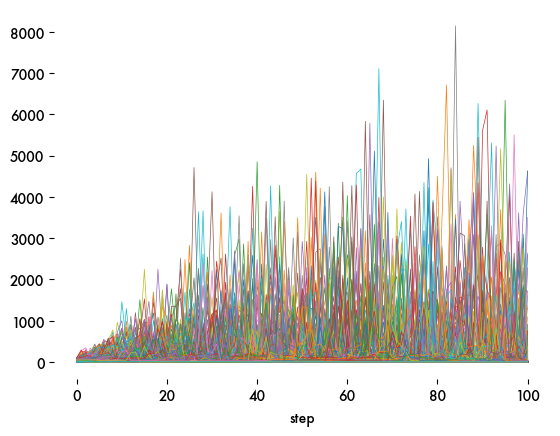

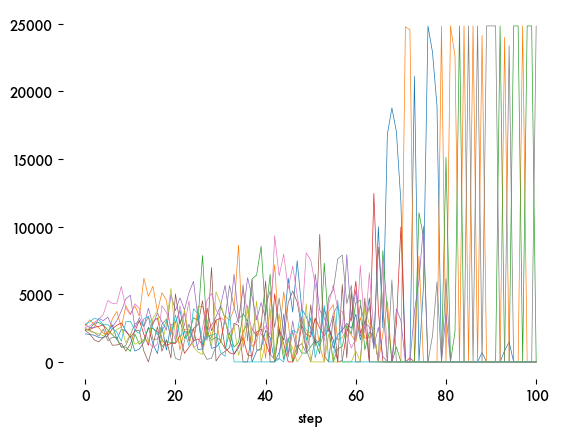

In [5]:
customer_wide = pd.pivot_table(customer_history, index = ['step'], values = ['balance'], columns = ['id'])
customer_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)
plt.show()

bank_wide = pd.pivot_table(bank_history, index = ['step'], values = ['reserves'], columns = ['id'])
bank_wide.plot(linewidth=.5, legend=None)
sns.despine(left = True, bottom = True)

These plots show the distribution of customer bank balances at the beginning of the simuation and the mean values at the end of the simulation steps.

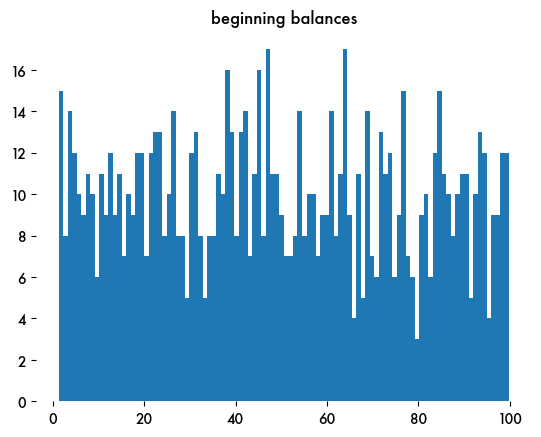

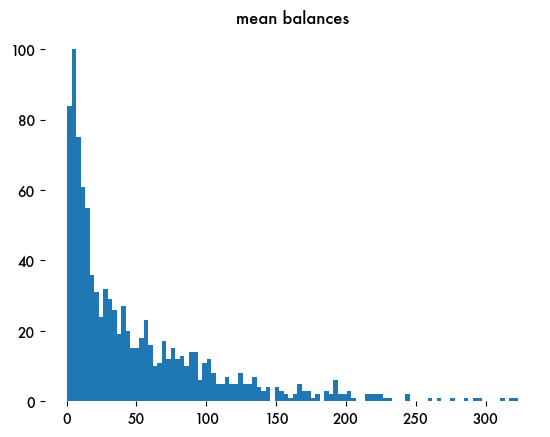

In [6]:
customer_history[customer_history['step'] == 0].hist('balance', bins = 100, grid=False)
plt.title('beginning balances')
sns.despine(left = True, bottom = True)
plt.show()

customer_history.groupby('id').mean().hist('balance', bins = 100, grid=False)
plt.title('mean balances')
sns.despine(left = True, bottom = True)

This new plot shows the movement of the market overnight rate over time.

,step,average_net_position,avg_daily_rate,average_risk_appetite,fed_recapitalization
0,0,0.000000,0.000000,0.0000,None
1,1,-0.002509,0.000000,0.2486,None
2,2,-0.007570,0.000000,0.2486,None
3,3,-0.013610,0.000000,0.2486,None
4,4,-0.010296,0.000000,0.2486,None
...,...,...,...,...,...
96,96,-5344.085676,0.599998,0.2486,None
97,97,-5497.986760,0.600000,0.2486,None
98,98,-8554.381744,0.599998,0.2486,None
99,99,-12512.177607,0.600000,0.2486,None


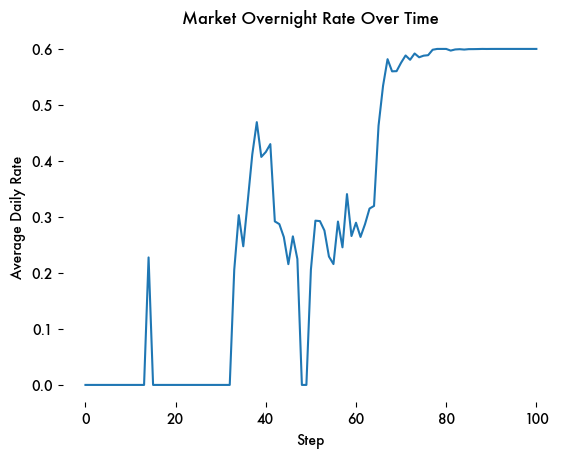

In [7]:
from IPython.display import display

display(financial_system_history)

plt.figure()
plt.plot(financial_system_history['step'], financial_system_history['avg_daily_rate'])
plt.title('Market Overnight Rate Over Time')
plt.xlabel('Step')
plt.ylabel('Average Daily Rate')
sns.despine(left=True, bottom=True)
plt.show()

This final plot shows, for each bank, mean reserve and loan values.

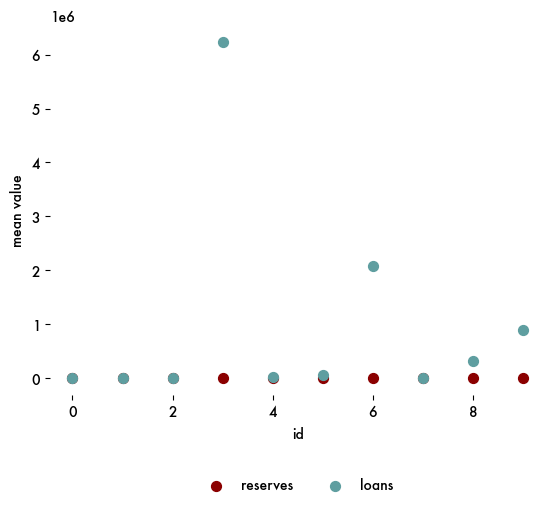

In [8]:
bank_means = bank_history[['id', 'reserves', 'loans']].groupby(by='id').mean()
bank_means = bank_means.reset_index()
ax = bank_means.plot.scatter(x = 'id', y = 'reserves', c = 'darkred', label = 'reserves', s = 50)
bank_means.plot.scatter(x = 'id', y = 'loans', c = 'cadetblue', label = 'loans', facecolors='none', s = 50, ax = ax)
plt.ylabel('mean value')
plt.legend(frameon=False, bbox_to_anchor=(0.5, -.3), loc='lower center', ncol=2)
sns.despine(left = True, bottom = True)

Letʻs see if we can discern what is happening with an animated plot

In [9]:
bank_history_output = widgets.Output()

def plot_bank_reserves_history():
    """Create an animated bar chart of bank reserves ordered by risk appetite"""
    with bank_history_output:
        clear_output(wait=True)
        plt.close('all')  # Close any existing figures
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sort banks by risk appetite
        sorted_indices = sorted(range(len(risk_appetites)), key=lambda k: risk_appetites[k])
        sorted_appetites = [risk_appetites[i] for i in sorted_indices]
        
        # Calculate y-axis limits once
        all_reserves = [r for step_data in bank_history.groupby('step')['reserves'] for r in step_data[1]]
        y_min = min(all_reserves)
        y_max = min(50000, max(all_reserves))
        
        def update(frame):
            ax.clear()
            step_data = bank_history[bank_history['step'] == frame]
            
            # Get reserves for this step, sorted by risk appetite
            reserves = [step_data[step_data['id'] == i]['reserves'].values[0] for i in sorted_indices]
            
            # Create bar plot with color gradient
            colors = plt.cm.viridis(np.linspace(0, 1, len(reserves)))
            bars = ax.bar(range(len(reserves)), reserves, color=colors)
            
            # Set static y-axis limits
            ax.set_ylim(y_min, y_max)
            
            # Customize the plot
            ax.set_title(f'Bank Reserves by Risk Appetite (Step {frame})')
            ax.set_xlabel('Banks (ordered by risk appetite)')
            ax.set_ylabel('Reserves')
            
            # Set x-ticks to show risk appetites
            ax.set_xticks(range(len(sorted_appetites)))
            ax.set_xticklabels([f'{a:.2f}' for a in sorted_appetites], rotation=45)
            
            sns.despine(left=True, bottom=True)
            plt.tight_layout()
        
        # Create animation
        global bank_history_anim
        bank_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=bank_history['step'].unique(),
            interval=200,
            repeat=False
        )
        
        # Display the animation
        display(HTML(bank_history_anim.to_jshtml()))
        plt.close()



# autorun animation
display(bank_history_output)
plot_bank_reserves_history()




Output()